In [1]:
# ideas for a source test
import cobra
import pandas as pd

from refinegems.utility.io import load_model

/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)


In [2]:
test_model_path = '/Users/brune/Documents/11_Test_Data/test_SPECIMEN/thesis/Kp_std/03_refinement/step4-smoothing/Kp_std_smooth.xml'
test_model = load_model(test_model_path,'cobra')


-----
### Plot the basic analysis

- one model  -  done more or less
- collection of models

#### Plot for a single report

/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)
/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/cobra/core/metabolite.py:129: UserWarning: invalid character '*' found in formula 'HO*'
  warn(f"invalid character '*' found in formula '{self.formula}'")
/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/cobra/core/metabolite.py:129: UserWarning: invalid character '*' found in formula 'C8H14NOS2*'
  warn(f"invalid character '*' found in formula '{self.formula}'")
/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/cobra/core/metabolite.py:129: UserWarning: invalid character '*' found in formula 'HO2*'
  warn(f"invalid character '*' found in formula '{self.formula}'")
/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/cobra/core/metabolite.py:129: UserWarn

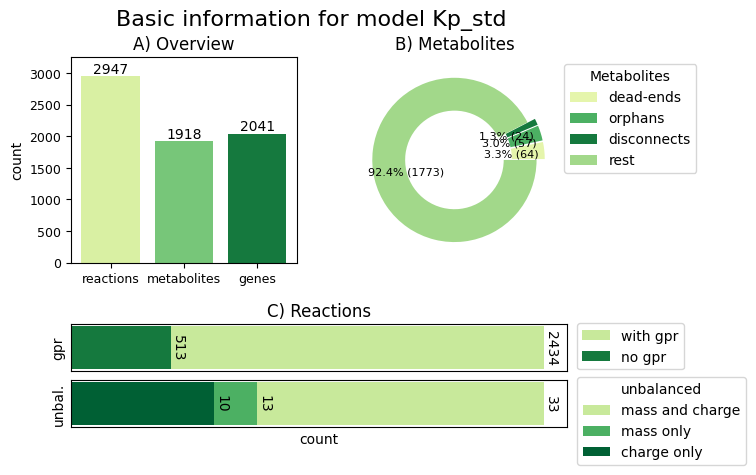

In [1]:
from refinegems.utility.io import load_model
from refinegems.classes.reports import ModelInfoReport
import matplotlib.pyplot as plt

test_model_path = '/Users/brune/Documents/11_Test_Data/test_SPECIMEN/thesis/Kp_std/03_refinement/step4-smoothing/Kp_std_smooth.xml'
test_model = load_model(test_model_path,'cobra')

rep = ModelInfoReport(test_model)
fig = rep.visualise()

plt.show()

#### Plot growth heatmap

In [1]:
from refinegems.classes.reports import GrowthSimulationReport, SingleGrowthSimulationReport

import pandas as pd

/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)


In [2]:
testfile = '/Users/brune/Documents/11_Test_Data/test_refinegems/test_growth_heatmap.tsv'

data = pd.read_csv(testfile, sep='\t')
data.head()

,model,medium,doubling_time [min],growth_value,complete
0,iShJCSC1435GOG23,VMH1,7.760722,5.358887,"EX_asn__L_e, EX_asn__L_e, EX_asn__L_e, EX_asn_..."
1,iShJCSC1435GOG23,VMH2,6.562501,6.337345,"EX_asn__L_e, EX_asn__L_e, EX_asn__L_e, EX_asn_..."
2,iShJCSC1435GOG23,CoreJCSC1435,8.383171,4.960990,"EX_asn__L_e, EX_asn__L_e, EX_asn__L_e, EX_asn_..."
3,iShJCSC1435GOG23,LB,57.578721,0.722295,"EX_asn__L_e, EX_asn__L_e, EX_asn__L_e, EX_asn_..."
4,iShJCSC1435GOG23,RPMI,inf,0.000000,"EX_asn__L_e, EX_asn__L_e, EX_asn__L_e, EX_asn_..."


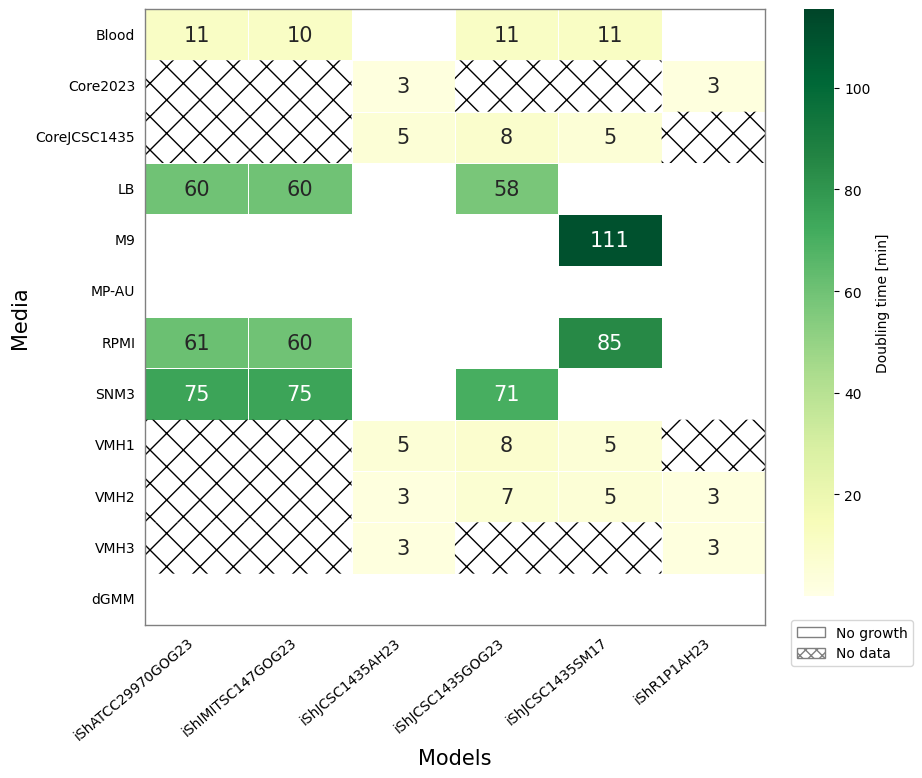

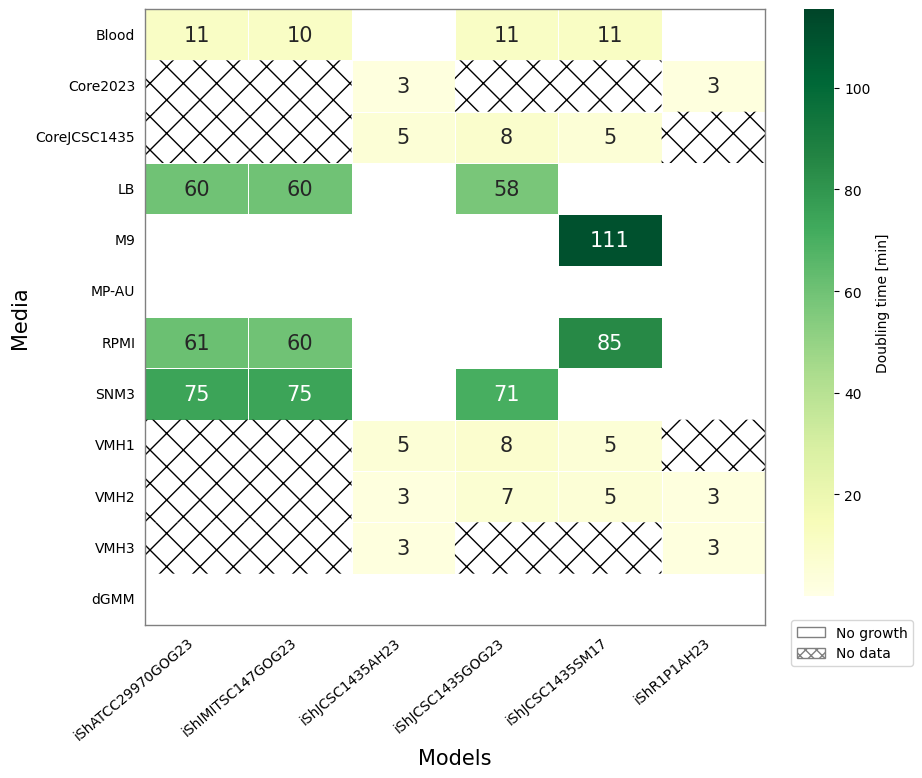

In [3]:
report = GrowthSimulationReport()

for idx in range(0,len(data)):
    temp = SingleGrowthSimulationReport(data.iloc[idx,0],
                                        data.iloc[idx,1],
                                        data.iloc[idx,3],
                                        data.iloc[idx,2])
    
    report.add_sim_results(temp)

report.plot_growth()

In [1]:
from refinegems.classes import egcs

/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)


/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)


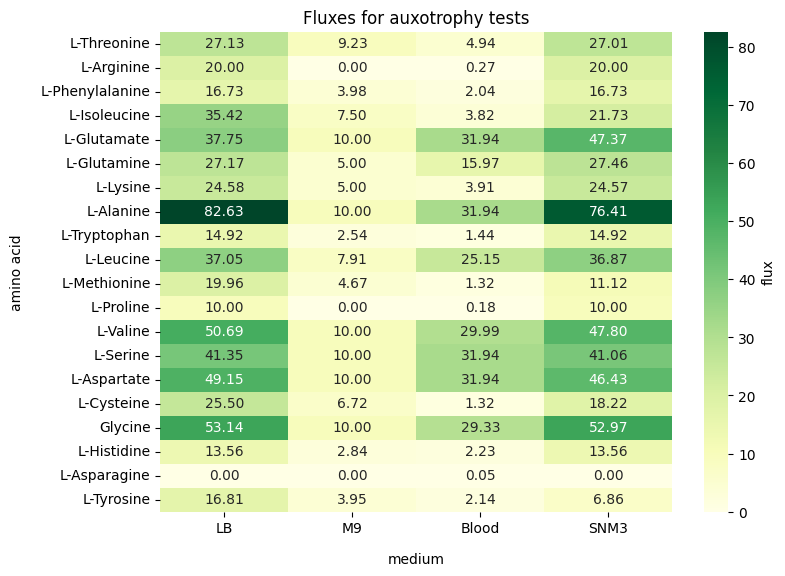

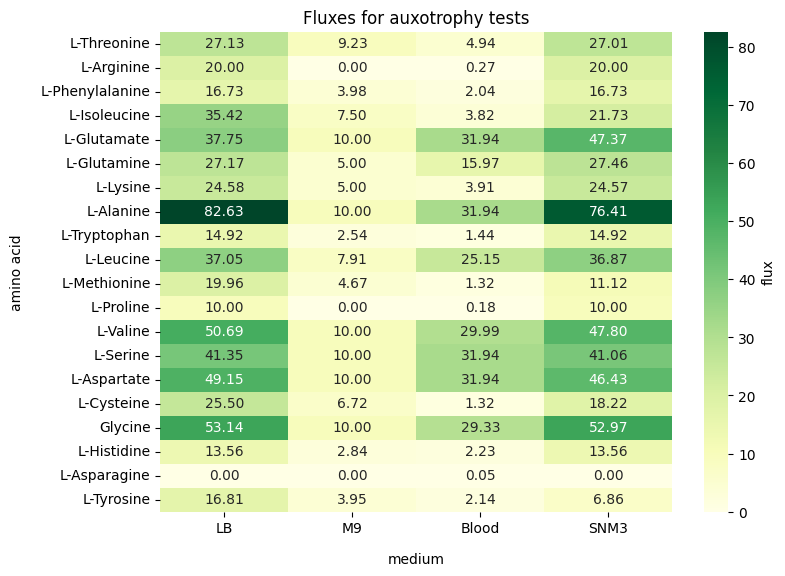

In [1]:
from refinegems.analysis.growth import test_auxotrophies
from refinegems.utility.io import load_model
from refinegems.classes.medium import load_medium_from_db
fp = '/Users/brune/Downloads/iShATCC29970GOG23.xml'


lb = load_medium_from_db('LB')
m9 = load_medium_from_db('M9')
blood = load_medium_from_db('Blood')
snm3 = load_medium_from_db('SNM3')
med_list = [lb,m9,blood,snm3]

mod = load_model(fp,'cobra')
res = test_auxotrophies(mod,med_list,['None','None','None','None'])
res.visualise_auxotrophies()


0.0
0.0
0.0
0.9124325929934498
2.5427767813298886e-15
2.6351789694066375e-15
2.6351789694066375e-15
-2.185451379858592e-15
-2.185451379858592e-15
-2.185451379858592e-15
0.7188413687435392
1.1040733344021454e-15
-1.445181443717709e-14
-1.445181443717709e-14
-1.445181443717709e-14
0.9693934959379032
1.6191257352800508e-14
0.9439869254069019
-4.502908888706298e-16
-1.0027331264038729e-15
-1.0027331264038729e-15
0.7591811960858507
-3.757709650289535e-15
-1.3307739785598261e-15
-1.3307739785598261e-15
0.6190505786696173
0.9816642996839351
0.6130259039528044
4.81975916652881e-15
-4.5438204750241924e-15
-4.5438204750241924e-15
-4.5438204750241924e-15
-4.5438204750241924e-15
-4.5438204750241924e-15
0.9451052556354208
0.3984427792929737
-1.152365191945738e-14
5.14604082852773e-16
5.14604082852773e-16
5.14604082852773e-16
0.5846653052860783
0.5843631929529579
0.9570686133017923
0.6021232420002388
0.5870060882490619
0.6055797338859132
0.6042085993847454
-6.356460185683986e-16
7.894301385855898e-1

(<Figure size 640x480 with 2 Axes>,
 column                                                 1   \
 row                                                         
 1                                    1-Methylnicotinamide   
 2                         1-Methyl-4-imidazoleacetic acid   
 3                                          2,2-Bipyridine   
 4                             2,3-Cyclic GMP [Cyclic GMP]   
 5                             3,5-Cyclic GMP [Cyclic GMP]   
 6                         3-Hydroxyhexadecanoylcarnithine   
 7       3-[(2R)-2,4-Dihydroxy-3,3-dimethylbutanamido]p...   
 8       4,5-Bis(hydroxymethyl)-2-methylpyridin-3-ol [P...   
 9       4-(Azaniumylmethyl)-3-hydroxy-5-(hydroxymethyl...   
 10                                    4-Aminobenzoic acid   
 11             4-Aminobutanoate [gamma-Aminobutyric acid]   
 12      4-Formyl-3-hydroxy-5-(hydroxymethyl)-2-methylp...   
 13                                   4-Hydroxydebrisoquin   
 14                               

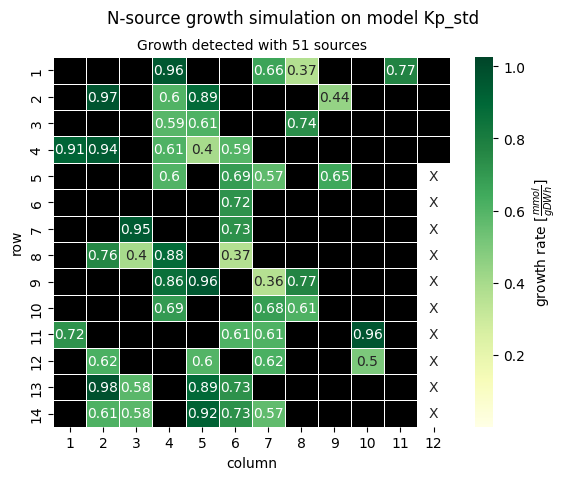

In [13]:
from refinegems.analysis.growth import test_growth_with_source
from refinegems.utility.io import load_model
from refinegems.classes.medium import load_medium_from_db

# m9 = load_medium_from_db('LB')
model_path = '/Users/brune/Documents/11_Test_Data/test_SPECIMEN/thesis/Kp_std/03_refinement/step4-smoothing/Kp_std_smooth.xml'
mod2 = load_model(model_path,'cobra')
rest = test_growth_with_source(mod2,'N')
rest.visualise()

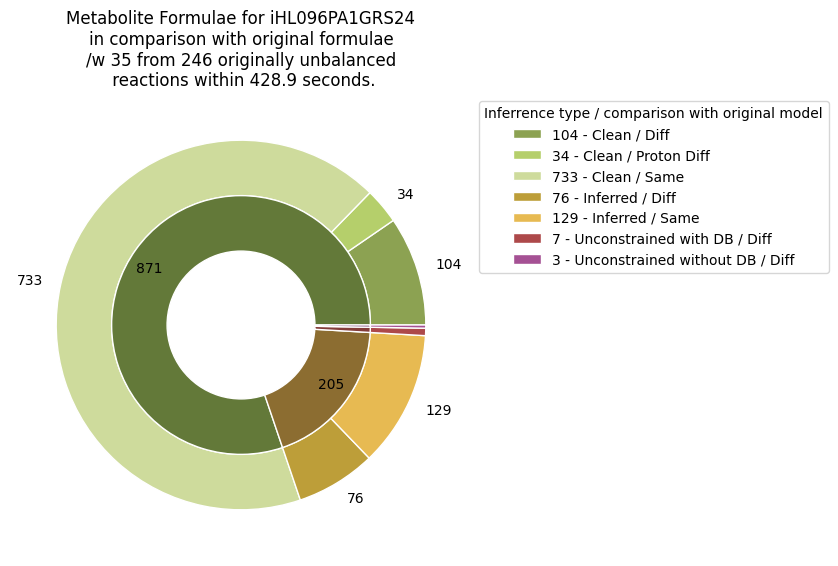

In [14]:
from refinegems.utility.connections import perform_mcc
from refinegems.utility.io import load_model

m = '/Users/brune/Downloads/iHL096PA1GRS24.xml'
mod = load_model(m,'cobra')

corr = perform_mcc(mod,dir='/Users/brune/Downloads/')
